##### 0. Setup Paths

In [1]:
import os
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [2]:
if os.name=='nt':
    !pip install wget
    import wget
import object_detection

# 2. Create Label Map

In [3]:
labels = [{'name':'licence', 'id':1}]
with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TF records

In [4]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

Successfully created the TFRecord file: Tensorflow\workspace\annotations\train.record
Successfully created the TFRecord file: Tensorflow\workspace\annotations\test.record


# 8. Load Train Model From Checkpoint

In [5]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()
@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [6]:
!pip install opencv-python
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [7]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'Cars428.png')

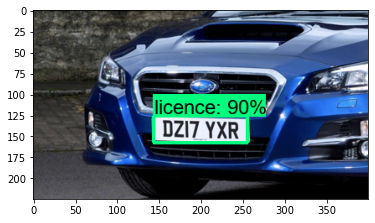

dict_keys(['detection_boxes', 'detection_scores', 'detection_classes', 'raw_detection_boxes', 'raw_detection_scores', 'detection_multiclass_scores', 'detection_anchor_indices', 'num_detections'])

In [8]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()
detections.keys()

# Apply OCR to Detection

In [9]:
!pip uninstall opencv-python-headless -y
!pip install easyocr
import easyocr

C:\Users\flurr\Desktop\ANPR\anprsys\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
!pip install easyocr
import easyocr

In [11]:
detection_threshold = 0.5

In [12]:
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]
width = image.shape[1]
height = image.shape[0]
for idx, box in enumerate(boxes):
    #print(box)
    roi = box*[height, width, height, width]
    #print(roi)
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(region)
    #print(ocr_result)
    #plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
    #for result in ocr_result:
        #print(np.sum(np.subtract(result[0][2],result[0][1])))
        #print(result[1])

# OCR Filtering

In [13]:
region_threshold = 0.05
import json
import string
import re
pattern = r'[' + string.punctuation + ']'
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    plate = [] 
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    sample_str = re.sub(pattern, '', plate[0])
    return sample_str
filter_text(region, ocr_result, region_threshold)

'DZI7 YXR'

# Bring it Together

In [14]:
region_threshold = 0.6
def ocr_it(image, detections, detection_threshold, region_threshold):
    
    # Scores, boxes and classes above threhold
    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    # Full image dimensions
    width = image.shape[1]
    height = image.shape[0]
    
    # Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi = box*[height, width, height, width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(region)
        
        text = filter_text(region, ocr_result, region_threshold)
        
        #plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        #plt.show()
        #print(text)
        return text, region
text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)
import csv
import uuid
'{}.jpg'.format(uuid.uuid1())

'de914a1c-ba0d-11ec-b618-d4548b0bace2.jpg'

In [15]:
def save_cropped(text,region):
    print(text)
    directory = r'C:\Users\flurr\Desktop\frontend\Eye-Conic-Frontend\src\assets\img'
    img_name = '{}.jpg'.format("license_plate_image")
    os.chdir(directory)
    cv2.imwrite(img_name, region)
    directory2 = r'C:\Users\flurr\Desktop'
    os.chdir(directory2)
    with open('output.txt', "a") as x:
        x.write('%s\n' % (text))

In [16]:
save_cropped(text, region)

DZI7 YXR


# Drone Code

In [16]:
from djitellopy import Tello
import cv2
import time
 
######################################################################
width = 1280  # WIDTH OF THE IMAGE
height = 1280  # HEIGHT OF THE IMAGE
startCounter =0  #  0 FOR FIGHT 1 FOR TESTING
######################################################################
 
# CONNECT TO TELLO
me = Tello()
me.connect()
me.streamoff()
me.streamon()
movement = 0
me.for_back_velocity = 0
me.left_right_velocity = 0
me.up_down_velocity = 0
me.yaw_velocity = 0
me.speed = 0
counter = 0
downCounter = 0
print(me.get_battery())
while True:
 
    # GET THE IMGAE FROM TELLO
    frame_read = me.get_frame_read()
    myFrame = frame_read.frame
    img = cv2.resize(myFrame, (width, height))
    image_np = np.array(myFrame)
    


    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    if counter < 3:
        if (detections['detection_scores'][0] > 0.83):
            try: 
                text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)
                #save_results(text, region, 'realtimeresults.csv', 'Detection_Images')\
                save_cropped(text,region)
                me.move_right()
                counter += 1
            except:
                pass

    if startCounter == 0:
        me.takeoff()
        startCounter = 1
        
    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if movement < 1:
        #speed should be 30
        #lands ~24ft
        me.left_right_velocity = 30
        movement += 1
        if me.send_rc_control:
            me.send_rc_control(me.left_right_velocity, me.for_back_velocity, me.up_down_velocity, me.yaw_velocity)
    '''if downCounter == 0:
        print("hi")
        me.left_right_velocity = 0; me.for_back_velocity = 0;me.up_down_velocity = 0; me.yaw_velocity = 0
        downCounter = 1
        if me.send_rc_control:
            me.send_rc_control(me.left_right_velocity, me.for_back_velocity, me.up_down_velocity, me.yaw_velocity)'''
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        #cap.release()
        #me.land()
        cv2.destroyAllWindows()
        break

[INFO] tello.py - 127 - Tello instance was initialized. Host: '192.168.10.1'. Port: '8889'.
[INFO] tello.py - 427 - Send command: 'command'
[INFO] tello.py - 451 - Response command: 'ok'
[INFO] tello.py - 427 - Send command: 'streamoff'
[INFO] tello.py - 451 - Response streamoff: 'ok'
[INFO] tello.py - 427 - Send command: 'streamon'
[INFO] tello.py - 451 - Response streamon: 'ok'


89


non-existing PPS 0 referenced
non-existing PPS 0 referenced
decode_slice_header error
no frame!
non-existing PPS 0 referenced
non-existing PPS 0 referenced
decode_slice_header error
no frame!
non-existing PPS 0 referenced
non-existing PPS 0 referenced
decode_slice_header error
no frame!
non-existing PPS 0 referenced
non-existing PPS 0 referenced
decode_slice_header error
no frame!
non-existing PPS 0 referenced
non-existing PPS 0 referenced
decode_slice_header error
no frame!
non-existing PPS 0 referenced
non-existing PPS 0 referenced
decode_slice_header error
no frame!
non-existing PPS 0 referenced
non-existing PPS 0 referenced
decode_slice_header error
no frame!
non-existing PPS 0 referenced
non-existing PPS 0 referenced
decode_slice_header error
no frame!
non-existing PPS 0 referenced
non-existing PPS 0 referenced
decode_slice_header error
no frame!
non-existing PPS 0 referenced
non-existing PPS 0 referenced
decode_slice_header error
no frame!
non-existing PPS 0 referenced
non-existi